In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from spellchecker import SpellChecker

stop=set(stopwords.words('english'))

In [12]:
tweet = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [19]:
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


Showing some of the tweets which have a target of '0', i.e. not diaster tweets

In [17]:
tweet[tweet['target']==0].head(3)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0


([<matplotlib.patches.Wedge at 0x7fd264d7e690>,
 [Text(-1.0732513534192263, -0.24110481617711227, '0'),
  Text(1.0732513534192263, 0.2411048161771121, '1')],
 [Text(-0.5854098291377597, -0.1315117179147885, '57.0%'),
  Text(0.5854098291377597, 0.1315117179147884, '43.0%')])

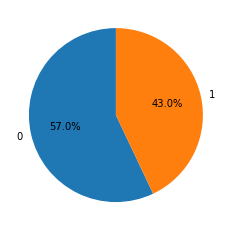

In [25]:
distribution = tweet.target.value_counts()
plt.pie(distribution,
       labels=distribution.keys(), 
       autopct='%1.1f%%', 
       startangle=90)

The distribution seems to contain more tweets which are not related to a disater than those that are.

Time to focus on cleaning the tweets up for the model

In [26]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

Many of the tweets habve urls and other html formatting in them which we will want to remove

In [34]:
def remove_links(text):
    link = re.compile(r'https?://\S+|www\.\S+')
    return link.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [37]:
df['text']=df['text'].apply(lambda x : remove_links(x))
df['text']=df['text'].apply(lambda x : remove_html(x))
df['text']=df['text'].apply(lambda x: remove_emoji(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))

With some of the extra mess gone from the tweets, we can make some adjustments to misspellings in an attempt to have consistent words

In [49]:
spell = SpellChecker()
def spell_check(text):
    corrected = []
    misspellings = spell.unknown(text.split())
    for word in text.split():
        if word in misspellings:
            corrected.append(spell.correction(word))
        else:
            corrected.append(word)
    return " ".join(corrected)

In [53]:
# This may take a while to run
df['text']=df['text'].apply(lambda x : spell_check(x))

KeyboardInterrupt: 

Now that we have some great, clean #tweets, its time to get into things

To start, we will create a corpus of all the words found amoung the tweets

In [ ]:
def corpus(df):
    corpus=[]
    for tweet in df['text']:
        words=[word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1 & word not in stop))]
        corpus.append(words)
        
    return corpus